# Data Science Development Workflow
In this notebook we show a data science development workflow using **Kedro** and **MLflow**. As a showcase we implement a simple regression pipeline.

We will

* Set up Kedro Project Template
* Create production-ready Kedro Pipeline
* MLflow Tracking: Compare different experiments
* MLflow Project: Use code packaging convention
* MLflow Model Deployment: Deploy the MLflow Model locally to make online predictions
* Create Airflow DAG from Kedro pipeline

You can find extensive information in the [Kedro Docs](https://kedro.readthedocs.io/en/stable/) and the [MLflow Docs](https://www.mlflow.org/docs/latest/index.html).


## Kedro Project Template

We create a new project based on a config file with following variables:

In [ ]:
!cat config.yml

In [ ]:
# Delete the directory, if you want to start over..

#!rm -fr /workshop/workspace/workflow-tutorial

In [ ]:
%%bash
cp /workshop/notebooks/kedro/config.yml /workshop/workspace
cd /workshop/workspace

kedro new --config config.yml

In a terminal, we could leave out the `--config` option and kedro asks interactively for the variables.

There are additional template options via [starters](https://kedro.readthedocs.io/en/stable/02_get_started/06_starters.html) like `kedro new --starter=pyspark`.

Let's change the working directory..

In [ ]:
import os
os.chdir("/workshop/workspace/workflow-tutorial")

As mentioned above, it is best practise to create an environment, we have already done this:

`conda env create -f environment.yml`

In [ ]:
!conda env list

Optional: Creating a project git repository (`git init`) and version your data with dvc (`dvc init`).

### Exploring the project template

In [ ]:
!ls

Move credentials to save place..

In [ ]:
!mv conf/base/credentials.yml conf/local/

### Install project dependencies
Additional project dependencies can be installed using `kedro install`

In [ ]:
%%writefile src/requirements.txt
kedro-viz
nbstripout

In [ ]:
!kedro install --build-reqs

### Ignore notebook output cells in git

Output cell from Jupyter notebooks are better not tracked by git. (large images, sensitive information)

The following command adds a git hook that removes all notebook output before committing to git.

In [ ]:
# !git init
# !kedro activate-nbstripout

## Set up the data
The [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality) is used to build a regression model.

We download and add the dataset to the `data/` directory.

In [ ]:
!wget -O data/01_raw/winequality-red.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

### Register the datasets
We have to register the dataset in the catalog file `notebooks/kedro/workflow-tutorial/conf/base/catalog.yml`.
```yaml
wines-red:
  type: pandas.CSVDataSet
  filepath: data/01_raw/winequality-red.csv
  load_args:
    sep: ';'
```
With jupyter magic, this could be done like this:

In [ ]:
%%writefile conf/base/catalog.yml

wines-red:
  type: pandas.CSVDataSet
  filepath: data/01_raw/winequality-red.csv
  load_args:
    sep: ';'

Kedro supports different data-connectors like `dask.ParquetDataSet`, `pandas.ExcelDataSet`, `pandas.HDFDataSet` any many more. Support for custom datasets can easily be [added](https://kedro.readthedocs.io/en/stable/07_extend_kedro/01_custom_datasets.html).

Let's have a look at the data..

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from pathlib import Path
from kedro.framework.context import load_context

context = load_context(Path.cwd())
df = context.catalog.load("wines-red")
df.head()

Note that the kedro context is automatically loaded when starting jupyter with `kedro jupyter notebook`.

We can also create a report..

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_file("data/08_reporting/wines-red.html")

## Create the pipeline
* Create for each data transformation step a `node` consisting of a Python function and the input / output data
* A `pipeline` consists of a list of different `node`s. The dependencies and execution order are determined via inputs and outputs.
* The whole project pipeline is registered in `src/workflow_tutorial/hooks.py` and can run via `kedro run`

### Python `node` functions
Note that we use **MLflow tracking** of the parameters and the model.

In [ ]:
%%writefile src/workflow_tutorial/pipelines/nodes.py

import logging

from typing import Dict, List

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from urllib.parse import urlparse

import mlflow
import mlflow.sklearn

def split_data(data: pd.DataFrame, parameters: Dict) -> List:
    """Splits data into training and test sets.

        Args:
            data: Source data.
            parameters: Parameters defined in parameters.yml.

        Returns:
            A list containing split data.

    """
    x = data.drop(["quality"], axis=1).values

    y = data["quality"].values
    
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=parameters["test_size"], random_state=parameters["random_state"]
    )

    return [x_train, x_test, y_train, y_test]

def train_model(x_train: np.ndarray, y_train: np.ndarray, parameters: Dict) -> Pipeline:
    """Train the linear regression model.

        Args:
            x_train: Training data of independent features.
            y_train: Target.
            parameters: Parameters defined in parameters.yml.

        Returns:
            Trained model.

    """
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('regressor', ElasticNet(alpha=parameters["alpha"],
                                              l1_ratio=parameters["l1_ratio"],
                                              random_state=parameters["random_state"]))])
    
    pipe.fit(x_train, y_train)

    mlflow.log_param("alpha", parameters["alpha"])
    mlflow.log_param("l1_ratio", parameters["l1_ratio"])
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    # Model registry does not work with file store
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(pipe, "model", registered_model_name="ElasticnetModel")
    else:
        mlflow.sklearn.log_model(pipe, "model")

    return pipe

Alternatively, you can **tag cells as node**

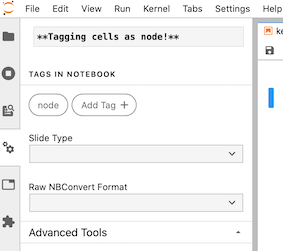

and run `kedro jupyter convert`.

### Assemble Pipeline

In [ ]:
%%writefile src/workflow_tutorial/pipelines/pipeline.py

from kedro.pipeline import Pipeline, node

from .nodes import split_data, train_model


def create_pipeline(**kwargs):
    return Pipeline(
        [
            node(
                func=split_data,
                inputs=["wines-red", "parameters"],
                outputs=["x_train", "x_test", "y_train", "y_test"],
                name="splitting_data",
            ),
            node(
                func=train_model,
                inputs=["x_train", "y_train", "parameters"],
                outputs="model",
                name="training_model",
            ),
        ]
    )

### Register Pipeline

In [ ]:
%%writefile src/workflow_tutorial/hooks.py

"""Project hooks."""
from typing import Any, Dict, Iterable, Optional

from kedro.config import ConfigLoader
from kedro.framework.hooks import hook_impl
from kedro.io import DataCatalog
from kedro.pipeline import Pipeline
from kedro.versioning import Journal

from workflow_tutorial.pipelines import pipeline as default_pipeline

class ProjectHooks:
    @hook_impl
    def register_pipelines(self) -> Dict[str, Pipeline]:
        """Register the project's pipeline.

        Returns:
            A mapping from a pipeline name to a ``Pipeline`` object.

        """
        return {
            "__default__": default_pipeline.create_pipeline(),
        }

    @hook_impl
    def register_config_loader(self, conf_paths: Iterable[str]) -> ConfigLoader:
        return ConfigLoader(conf_paths)

    @hook_impl
    def register_catalog(
        self,
        catalog: Optional[Dict[str, Dict[str, Any]]],
        credentials: Dict[str, Dict[str, Any]],
        load_versions: Dict[str, str],
        save_version: str,
        journal: Journal,
    ) -> DataCatalog:
        return DataCatalog.from_config(
            catalog, credentials, load_versions, save_version, journal
        )


project_hooks = ProjectHooks()



#### Set Parameters
The configuration includes a `parameters.yml` file, where we set the size of the test set, the random seed and some hyperparameters.

In [ ]:
%%writefile conf/base/parameters.yml
test_size: 0.25
random_state: 42

alpha: 0.5
l1_ratio: 0.5

## Run Pipeline
The Kedro pipeline can now be executed with

In [ ]:
!kedro run

Having independent nodes, Kedro's `ParallelRunner` can take advantage of multiple CPU cores:
`kedro run --parallel`

## Kedro Visualization

In [ ]:
!kedro viz --host=0.0.0.0 --no-browser

**Interrupt the kernel to go on..**

## Documentation and Packaging

This command creates documentation based on the code structure of your project including docstrings.

In [ ]:
#!kedro build-docs

This command creates `.egg` and `.whl` packaging files, which can be used to `pip install` on a target system.

In [ ]:
#!kedro package

## MLflow Tracking

Since we integrated **MLflow tracking** code in the python `node` functions, the parameters and the model are tracked for every run.

To compare runs with different parameters, let's run the pipeline again.

In [ ]:
!kedro run --params alpha:0,l1_ratio:0

Results can be compared with MLflow tracking UI.

In [ ]:
!mlflow ui --host=0.0.0.0

**Interrupt the kernel to go on..**

## MLflow Project

The conventions for **MLflow project** packaging include the MLproject file that we can create:

In [ ]:
%%writefile MLproject
name: workflow-tutorial

conda_env: ../../environment.yml

entry_points:
  main:
    command: "kedro run"

The file specifies the conda environment and command for different entry points (e.g. main, test, ...)

Now the project can also be run with the following command. (We do not want to re-create the conda environment, hence the option `--no-conda`)

In [ ]:
!mlflow run . --no-conda

## MLflow Model Deployment

We want to deploy an **MLflow Model** that has been created as an artifact for each run (`mlruns` directory).

We will pick one of the models..

In [ ]:
ids = os.listdir( 'mlruns/0/' )
ids.remove('meta.yaml')
model_path = '/workshop/workspace/workflow-tutorial/mlruns/0/' + ids[0] + '/artifacts/model'
model_path

And get some sample data..

In [ ]:
df_sample = df.sample(2, random_state = 0)
# file for batch prediction
df_sample.drop('quality', axis=1).to_json('/tmp/wine_sample.json', orient='split')
# json for api 
payload = "'" + df_sample.drop('quality', axis=1).to_json(orient='split')+ "'"
df_sample

### Batch predictions

First we make batch predictions on the sample data file..

In [ ]:
%%bash -s $model_path
mlflow models predict -m $1 -i '/tmp/wine_sample.json' --no-conda

### Online predictions

In order to deploy the model locally, use a terminal to execute following command.

`mlflow models serve --no-conda -m {{ model_path }}`

The path to the model file should be changed.

In [ ]:
%%bash -s $model_path
echo mlflow models serve --no-conda -m $1

Now you get can online predictions using the REST API.

In [ ]:
%%bash -s $payload
curl http://127.0.0.1:5000/invocations -H 'Content-Type: application/json; format=pandas-split' -d "$1"

### Docker
Alternative: Package a REST API endpoint serving the model as a docker image.

`mlflow models build-docker`

## Create Airflow DAG from Kedro pipeline
### Install more project dependencies
We want to use the *kedro-airflow* plugin. Please install this new project dependency using `kedro install`.
Note that to further update the project requirements, you should modify `src/requirements.in` (not `src/requirements.txt`).

In [ ]:
%%writefile src/requirements.in
kedro-airflow

In [ ]:
!kedro install --build-reqs

### Create and deploy airflow DAG.

Important:
* All data sets must have an entry in the data catalog, otherwise there are only MemoryDataSets.
* All local paths in both the data catalog and log config must be absolute paths.

In [ ]:
%%writefile conf/base/catalog.yml

wines-red:
  type: pandas.CSVDataSet
  filepath: /workshop/workspace/workflow-tutorial/data/01_raw/winequality-red.csv
  load_args:
    sep: ';'

x_train:
  type: pickle.PickleDataSet
  filepath: /workshop/workspace/workflow-tutorial/data/05_model_input/x_train.pickle

y_train:
  type: pickle.PickleDataSet
  filepath: /workshop/workspace/workflow-tutorial/data/05_model_input/y_train.pickle

x_test:
  type: pickle.PickleDataSet
  filepath: /workshop/workspace/workflow-tutorial/data/05_model_input/x_test.pickle

y_test:
  type: pickle.PickleDataSet
  filepath: /workshop/workspace/workflow-tutorial/data/05_model_input/y_test.pickle

model:
  type: pickle.PickleDataSet
  filepath: /workshop/workspace/workflow-tutorial/data/06_models/model.pickle

We need to run the project again in order to create the intermediate data sets.

In [ ]:
!kedro run

In [ ]:
!kedro airflow create

In [ ]:
#!kedro airflow deploy
#!cp /workshop/workspace/workflow-tutorial/airflow_dags/workflow_tutorial_dag.py /workshop/notebooks/airflow/dags/